In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Load Dataset:

In [2]:
data = pd.read_csv('CustomerChurn-Features.csv') #make dataframe

### Data Preparation:

In [3]:
ft = data.copy()

In [4]:
ft.iloc[:,:-1]

# We can see that there are 10 features

,Tenure,Monthly Charges,Device Protection,Streaming TV,Tech Support,Internet Service,Online Security,Streaming Movies,Online Backup,Payment Method
0,1,29.85,No,No,No,DSL,No,No,Yes,Electronic check
1,34,56.95,Yes,No,No,DSL,Yes,No,No,Mailed check
2,2,53.85,No,No,No,DSL,Yes,No,Yes,Mailed check
3,45,42.30,Yes,No,Yes,DSL,Yes,No,No,Bank transfer (automatic)
4,2,70.70,No,No,No,Fiber optic,No,No,No,Electronic check
...,...,...,...,...,...,...,...,...,...,...
7038,24,84.80,Yes,Yes,Yes,DSL,Yes,Yes,No,Mailed check
7039,72,103.20,Yes,Yes,No,Fiber optic,No,Yes,Yes,Credit card (automatic)
7040,11,29.60,No,No,No,DSL,Yes,No,No,Electronic check
7041,4,74.40,No,No,No,Fiber optic,No,No,No,Mailed check


In [5]:
# Check data imbalance

ft.groupby(by = 'Churn').size()

Churn
No     5174
Yes    1869
dtype: int64

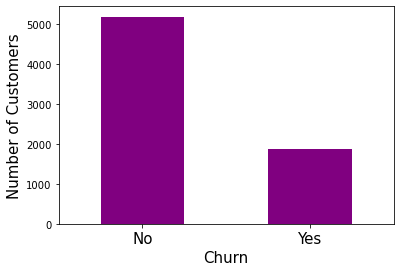

In [6]:
ft.groupby(by = 'Churn').size().plot(kind = 'bar', color = 'purple')
plt.xticks(rotation = 0, fontsize = 15)
plt.xlabel('Churn', fontsize = 15)
plt.ylabel('Number of Customers', fontsize = 15)
plt.show()

# data is imbalanced

In [7]:
# one method to deal with data imbalance is with up-sampling minority class

ft_maj, ft_min = ft[ft['Churn']== 'No'], ft[ft['Churn']== 'Yes'] # separate data into majority and minority

In [8]:
from sklearn.utils import resample

ft_min_up = resample(ft_min, 
                      replace=True,     # sample with replacement
                      n_samples= len(ft_maj),    # match the number of up-sampled data with majority
                      random_state= 0)

In [9]:
# join the two classes

ft_new = pd.concat([ft_maj, ft_min_up])

In [10]:
# Shuffle
from sklearn.utils import shuffle

ft_new = shuffle(ft_new, random_state = 0)

In [11]:
ft_new_dum = pd.get_dummies(ft_new, drop_first = False) #get dummy variables

In [12]:
# convert numerical variables into scale
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()
ft_new_dum = pd.DataFrame(mm.fit_transform(ft_new_dum), columns = ft_new_dum.columns)
ft_new_dum.iloc[:,:-2]

,Tenure,Monthly Charges,Device Protection_No,Device Protection_No internet service,Device Protection_Yes,Streaming TV_No,Streaming TV_No internet service,Streaming TV_Yes,Tech Support_No,Tech Support_No internet service,...,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Online Backup_No,Online Backup_No internet service,Online Backup_Yes,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,0.111111,0.061194,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.902778,0.539303,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.527778,0.608955,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.513889,0.013433,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.055556,0.059701,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10343,0.375000,0.666667,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
10344,0.402778,0.505473,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
10345,0.375000,0.508458,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10346,0.777778,0.819900,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
x = ft_new_dum.iloc[:, :-2] # features
y = ft_new.iloc[:, -1] #target

In [15]:
# Establish models hyperparameters

test_ratio = 0.05
random_state = 0
depth = 40

In [16]:
# Dataset split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= test_ratio, random_state= random_state)

# 3. Model Building

## 3.1. Decision Tree

In [17]:
acc_train_dt = []
acc_test_dt = []

for i in range(depth):
    #configure model
    # After trials and errors, we found out that gini criterion performs slightly better than entropy
    # Thus, we choose gini as the criterion
    clf = DecisionTreeClassifier(max_depth = i+1, random_state = random_state, criterion = 'gini')
    clf = clf.fit(X_train, y_train)
    
    # evaluate train dataset
    train_pred = clf.predict(X_train)
    train_acc = metrics.accuracy_score(y_train, train_pred)
    train_acc = [train_acc]
    acc_train_dt = acc_train_dt + train_acc
    
    # evaluate test dataset
    test_pred = clf.predict(X_test)
    test_acc = metrics.accuracy_score(y_test, test_pred)
    test_acc = [test_acc]
    acc_test_dt = acc_test_dt + test_acc
    
conf_mat_dt = confusion_matrix(y_test, test_pred) # Confusion Matrix
report_dt = classification_report(y_test, test_pred) # Report

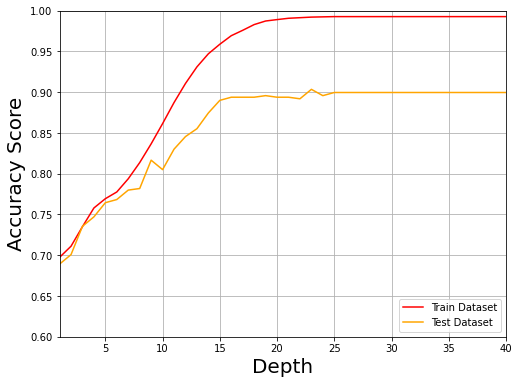

In [18]:
plt.figure(figsize = [8,6])
plt.plot(np.array(range(depth))+1, acc_train_dt, color = 'red', label = 'Train Dataset')
plt.plot(np.array(range(depth))+1, acc_test_dt, color = 'orange', label = 'Test Dataset')

plt.legend(loc = 'lower right', frameon = True)
plt.xlabel('Depth', fontsize = 20)
plt.ylabel('Accuracy Score', fontsize = 20)
plt.xlim([1, depth])
plt.ylim([0.6,1])
plt.grid()
#plt.show()

# The accuracy for test dataset starts to flatten at the depth of 15
# Furthermore, the test dataset, although has lower accuracy than train dataset, does not diverge from the train dataset
# Therefore, the model does not overfit
# Later, we can pick 15 as the maximum tree depth

In [19]:
importance_dt = pd.DataFrame({'feature' : X_train.columns, 'importance' : np.round(clf.feature_importances_, 4)})
sort_dt = importance_dt.sort_values(by = 'importance', ascending = False)
sort_dt['sum'] = sort_dt['importance'].cumsum(axis = 0)
sort_dt

,feature,importance,sum
1,Monthly Charges,0.3264,0.3264
0,Tenure,0.2840,0.6104
8,Tech Support_No,0.1648,0.7752
12,Internet Service_Fiber optic,0.0286,0.8038
11,Internet Service_DSL,0.0285,0.8323
25,Payment Method_Electronic check,0.0230,0.8553
23,Payment Method_Bank transfer (automatic),0.0201,0.8754
20,Online Backup_No,0.0170,0.8924
24,Payment Method_Credit card (automatic),0.0146,0.9070
16,Online Security_Yes,0.0141,0.9211


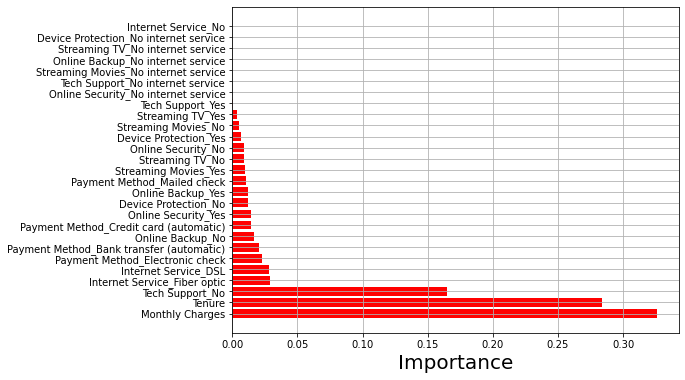

In [20]:
plt.figure(figsize = [8,6])
plt.barh(sort_dt['feature'], sort_dt['importance'], color = 'r', align = 'center')
plt.xlabel('Importance', fontsize = 20)
plt.grid()
# plt.show()

In [21]:
# Based on the information on feature importance above
# We would like to reduce the dimensionality by picking only the top 90% most important features

dt_90 = sort_dt[sort_dt['sum'] < 0.91]
incl_dt = dt_90['feature'].str.split('_', n = 0, expand = True)[0].unique() # top 90% features

## 3.2. Random Forest

In [22]:
estimator = 50
acc_train_rf = []
acc_test_rf = []

for i in range(depth):
    #configure model
    # After trials and errors, we found out that gini criterion performs slightly better than entropy
    rf = RandomForestClassifier(n_estimators = estimator, max_depth = i+1, random_state = random_state, criterion = 'gini')
    rf = rf.fit(X_train, y_train)
    
    # evaluate train dataset
    train_pred = rf.predict(X_train)
    train_acc = metrics.accuracy_score(y_train, train_pred)
    train_acc = [train_acc]
    acc_train_rf = acc_train_rf + train_acc
    
    # evaluate test dataset
    test_pred = rf.predict(X_test)
    test_acc = metrics.accuracy_score(y_test, test_pred)
    test_acc = [test_acc]
    acc_test_rf = acc_test_rf + test_acc
    
conf_mat_rf = confusion_matrix(y_test, test_pred)
report_rf = classification_report(y_test, test_pred)

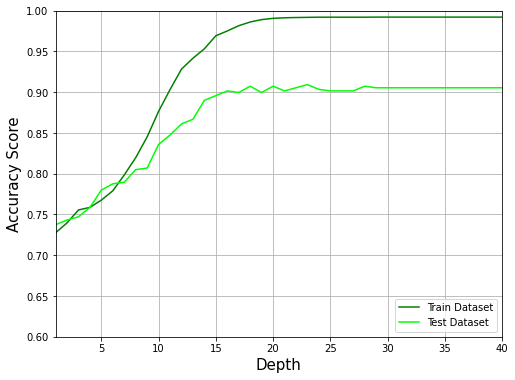

In [23]:
plt.figure(figsize = [8,6])
plt.plot(np.array(range(depth))+1, acc_train_rf, color = 'green', label = 'Train Dataset')
plt.plot(np.array(range(depth))+1, acc_test_rf, color = 'lime', label = 'Test Dataset')

plt.legend(loc = 'lower right', frameon = True)
plt.xlabel('Depth', fontsize = 15)
plt.ylabel('Accuracy Score', fontsize = 15)
plt.xlim([1, depth])
plt.ylim([0.6,1])
plt.grid()
plt.show()

# Similar with that of Decision Tree, the test dataset of Random Forest flattens at the depth of 15
# It also does not diverge from train dataset

In [24]:
importance_rf = pd.DataFrame({'feature' : X_train.columns, 'importance' : np.round(rf.feature_importances_, 4)})
sort_rf = importance_rf.sort_values(by = 'importance', ascending = False)
sort_rf['sum'] = sort_rf['importance'].cumsum(axis = 0)

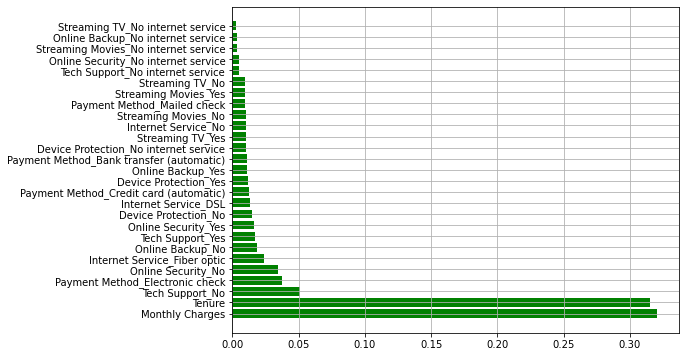

In [25]:
plt.figure(figsize = [8,6])
plt.barh(sort_rf['feature'], sort_rf['importance'], color = 'g', align = 'center')
plt.grid()
plt.show()

In [26]:
# We would like to pick the top 90% most important features

rf_90 = sort_rf[sort_rf['sum'] < 0.91] 
incl_rf = rf_90['feature'].str.split('_', n = 0, expand = True)[0].unique() # top 90% most important features

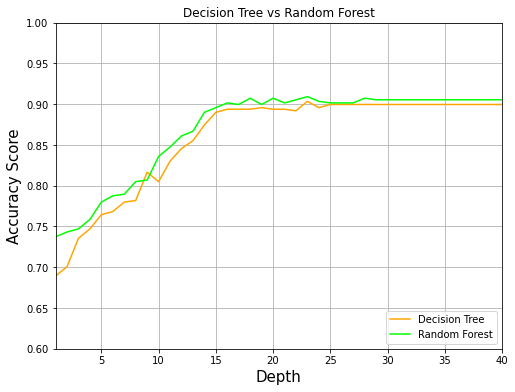

In [27]:
plt.figure(figsize = [8,6])

plt.plot(np.array(range(depth))+1, acc_test_dt, color = 'orange', label = 'Decision Tree')
plt.plot(np.array(range(depth))+1, acc_test_rf, color = 'lime', label = 'Random Forest')

plt.legend(loc = 'lower right', frameon = True)
plt.title('Decision Tree vs Random Forest')
plt.xlabel('Depth', fontsize = 15)
plt.ylabel('Accuracy Score', fontsize = 15)
plt.xlim([1, depth])
plt.ylim([0.6,1])
plt.grid()
#plt.show()

# Based on the graph below
# Decision tree and random forest perform very similarly
# However, decision tree takes much less computation time
# Therefore, we pick Decision Tree as our chosen model

In [28]:
print(acc_test_dt[15]) # Decision Tree at depth of 15
print(acc_test_rf[15]) # Random Forest at depth of 15

0.8938223938223938
0.9015444015444015


## 3.3. Updated Chosen Model - Decision Tree

In [29]:
ft_final = pd.get_dummies(ft_new[incl_dt], drop_first = False) #get dummy variables
ft_final

,Monthly Charges,Tenure,Tech Support_No,Tech Support_No internet service,Tech Support_Yes,Internet Service_DSL,Internet Service_Fiber optic,Internet Service_No,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,Online Backup_No,Online Backup_No internet service,Online Backup_Yes
2347,24.40,8,0,1,0,0,0,1,0,0,0,1,0,1,0
5992,72.45,65,1,0,0,1,0,0,0,1,0,0,0,0,1
1039,79.45,38,1,0,0,0,1,0,0,0,1,0,0,0,1
6042,19.60,37,0,1,0,0,0,1,0,0,0,1,0,1,0
660,24.25,4,1,0,0,1,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4558,85.25,27,1,0,0,0,1,0,0,0,1,0,1,0,0
6611,69.05,29,0,0,1,1,0,0,1,0,0,0,1,0,0
4420,69.35,27,0,0,1,1,0,0,0,1,0,0,1,0,0
4691,100.65,56,1,0,0,0,1,0,1,0,0,0,1,0,0


In [30]:
# convert numerical variables into scale

mm = MinMaxScaler()
ft_final = pd.DataFrame(mm.fit_transform(ft_final), columns = ft_final.columns)

In [31]:
x = ft_final # features
y = ft_new.iloc[:, -1] #target

In [32]:
# Establish models hyperparameters

max_depth = 15

In [33]:
# Dataset split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= test_ratio, random_state= random_state)

In [34]:
acc_train_dt = []
acc_test_dt = []

for i in range(max_depth):
    #configure model
    # After trials and errors, we found out that gini criterion performs slightly better than entropy
    dt = DecisionTreeClassifier(max_depth = i+1, random_state = random_state, criterion = 'gini')
    dt = dt.fit(X_train, y_train)
    
    # evaluate train dataset
    train_pred = dt.predict(X_train)
    train_acc = metrics.accuracy_score(y_train, train_pred)
    train_acc = [train_acc]
    acc_train_dt = acc_train_dt + train_acc
    
    # evaluate test dataset
    test_pred = dt.predict(X_test)
    test_acc = metrics.accuracy_score(y_test, test_pred)
    test_acc = [test_acc]
    acc_test_dt = acc_test_dt + test_acc
    
conf_mat_dt1 = confusion_matrix(y_test, test_pred)
report_dt1 = classification_report(y_test, test_pred)

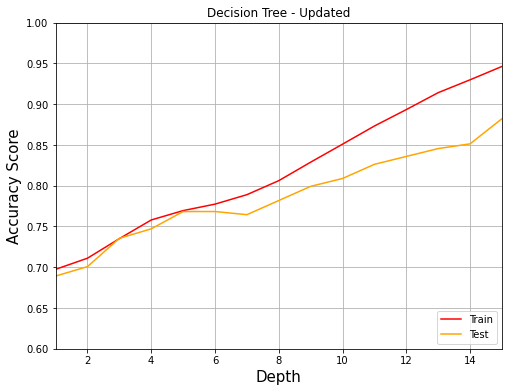

In [35]:
plt.figure(figsize = [8,6])

plt.plot(np.array(range(max_depth))+1, acc_train_dt, color = 'red', label = 'Train')
plt.plot(np.array(range(max_depth))+1, acc_test_dt, color = 'orange', label = 'Test')

plt.legend(loc = 'lower right', frameon = True)
plt.title('Decision Tree - Updated')
plt.xlabel('Depth', fontsize = 15)
plt.ylabel('Accuracy Score', fontsize = 15)
plt.xlim([1, max_depth])
plt.ylim([0.6,1])
plt.grid()

In [36]:
print(conf_mat_dt1)
print()
print(report_dt1)

[[201  46]
 [ 15 256]]

              precision    recall  f1-score   support

          No       0.93      0.81      0.87       247
         Yes       0.85      0.94      0.89       271

    accuracy                           0.88       518
   macro avg       0.89      0.88      0.88       518
weighted avg       0.89      0.88      0.88       518

